In [10]:
# import gymnasium as gym
import gym
import numpy as np
from stable_baselines3.common.env_util import make_vec_env as make_vec_env_sb3
from copy import deepcopy
import torch
from torch.distributions import Normal
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
from torch.utils.data import Dataset, DataLoader
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv
import imageio
import pandas as pd
from tqdm import tqdm
from PIL import Image
from stable_baselines3.dqn.policies import MlpPolicy
import matplotlib.pyplot as plt


In [11]:
import gc
gc.collect()

10399

In [12]:
!nvidia-smi
# clean up memory forcefully
torch.cuda.empty_cache()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device



Sat Sep 14 23:10:18 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.06              Driver Version: 545.23.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1080 Ti     On  | 00000000:01:00.0 Off |                  N/A |
|  0%   45C    P8              17W / 250W |    196MiB / 11264MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

device(type='cuda')

In [13]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
class CustomDataset(Dataset):
    def __init__(self, observations, actions):
        self.observations = torch.tensor(observations, dtype=torch.float32,device=device)
        self.actions = torch.tensor(actions, dtype=torch.float32,device=device)

    def __len__(self):
        return len(self.observations)

    def __getitem__(self, idx):
        observation = self.observations[idx]
        action = self.actions[idx]
        return observation, action

class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.norm1 = nn.LayerNorm(32)
        self.fc2 = nn.Linear(32, 32)
        self.norm2 = nn.LayerNorm(32)
        self.fc3 = nn.Linear(32, output_dim)

    def forward(self, x):
        x = F.relu(self.norm1(self.fc1(x)))
        x = F.relu(self.norm2(self.fc2(x)))
        # x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    

Using device: cuda


In [14]:
env_id = "CartPole-v1"
# env = make_vec_env(env_id, n_envs=1)
# /mnt/nfs/work/c98181/RL/CartPole-v1/dataset
observations= np.load("/mnt/nfs/work/c98181/RL/CartPole-v1/dataset/CartPole-v1_obs.npy", allow_pickle=True)
actions = np.load("/mnt/nfs/work/c98181/RL/CartPole-v1/dataset/CartPole-v1_actions.npy", allow_pickle=True)

observations=observations.squeeze()
actions=actions.squeeze()

# observations = observations[:1000]
# actions = actions[:1000]

env=gym.make(env_id)
print(actions)
print(observations)

[0 0 1 0 1 1 0 1 0 1 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 0 1 1 0 0 1 0 1
 0 1 1 0 0 1 0 1 1 0 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 0 1 1
 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 0 1 1 0 0 1
 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1
 0 1 0 1 0 0 1 1 0 0 1 1 0 1 0 0 1 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 0 1 0 0 1
 1 0 1 0 1 0 0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 0 1 1 0 1 0 0
 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 0 1 0 1 0
 0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 0 1 0 1
 0 0 1 1 0 1 0 0 1 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 0 1 0 1 0 0 1 1 0 1 0 0 1
 1 0 1 0 1 0 0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 0 1 1 0 1 0 0
 1 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 0 1 1 0 1 0 0 1
 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 0
 1 1 0 1 0 1 0 0 1 1 0 1 

In [15]:
class mydataset(Dataset):
    def __init__(self, observations, actions):
        self.observations = torch.tensor(observations, dtype=torch.float32).to(device)
        self.actions = torch.tensor(actions, dtype=torch.float32).to(device)

    def __len__(self):
        return len(self.observations)

    def __getitem__(self, idx):
        observation = self.observations[idx]
        action = self.actions[idx]
        return observation, action

In [16]:
# import numpy as np
# import gymnasium as gym
# from imitation.policies.serialize import load_policy
# from imitation.util.util import make_vec_env
# from imitation.data.wrappers import RolloutInfoWrapper
# env = make_vec_env(
#     "seals:seals/CartPole-v0",
#     rng=np.random.default_rng(),
#     post_wrappers=[
#         lambda env, _: RolloutInfoWrapper(env)
#     ],  # needed for computing rollouts later
# )
# from stable_baselines3.common.evaluation import evaluate_policy

# # reward, _ = evaluate_policy(expert, env, 10)
# print(reward)

In [17]:
# 导入IPython显示控制模块

from tqdm import tqdm
policy_network = PolicyNetwork(4,2).to(device)


prev = PolicyNetwork(4,2).to(device)
prev.load_state_dict(policy_network.state_dict())
prev.eval()

# optimizer = torch.optim.Adam(policy_network.parameters(), lr=3e-4,weight_decay=1e-3)
optimizer = torch.optim.Adam(policy_network.parameters(), lr=3e-5)

# Training loop
num_epochs = 100000
batch_size = observations.shape[0]
mean=observations.mean(axis=0)
std=observations.std(axis=0)
print(mean)
print(std)

Normlization=False
# dataset = mydataset(observations=observations, actions=actions)
# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
normalize_obs= (observations-mean)/std
print(normalize_obs)
loss_graph=[]
eval_rewards=[]
margin_graph=[]
positive_reward_graph=[]
negative_reward_graph=[]
num_test = 1
if Normlization:
    obs_batch = torch.tensor(np.array(normalize_obs), dtype=torch.float32).to(device)
else:
    obs_batch = torch.tensor(np.array(observations), dtype=torch.float32).to(device)
act_batch = torch.tensor(np.array(actions), dtype=torch.float32).to(device)
test_score=0
for epoch in tqdm(range(1,1+num_epochs)):
    policy_network.train()

    # for step, (obs_batch,act_batch) in enumerate(pbar):
    


    
    logits = policy_network(obs_batch)
    model_dist = Categorical(logits=logits)
    model_act_sample = model_dist.sample()
    policy_chosen_logps = model_dist.log_prob(act_batch)
    policy_rejected_logps = model_dist.log_prob(model_act_sample)
    # with torch.no_grad():
    #     prev_dist = Categorical(logits=prev(obs_batch))
    #     reference_chosen_logps = prev_dist.log_prob(act_batch)
    #     reference_rejected_logps = prev_dist.log_prob(model_act_sample)


    pi_logratios = policy_chosen_logps - policy_rejected_logps
    # ref_logratios = reference_chosen_logps - reference_rejected_logps

    # logits = pi_logratios-ref_logratios
    logits = pi_logratios

    chosen_logratios = policy_chosen_logps 
    reject_logratios = policy_rejected_logps


    beta = 1
    # losses = (-F.logsigmoid(beta * logits))-policy_chosen_logps
    # if epoch <5000:
    #     losses=-policy_chosen_logps

    # else:
    #     losses = (-F.logsigmoid(beta * logits))
    # losses = (-F.logsigmoid(beta * logits))
    losses=-policy_chosen_logps
    loss = losses.mean()
    # Optimize the policy
    optimizer.zero_grad()



    loss.backward()

    optimizer.step()
    # pbar.set_description((f"Epoch [{epoch+1}/{num_epochs}]"))
    positive_reward = chosen_logratios.detach().mean().item()
    negative_reward = reject_logratios.detach().mean().item()
    margin = positive_reward - negative_reward
    loss_graph.append(loss.detach().item())
    margin_graph.append(margin)
    positive_reward_graph.append(positive_reward)
    negative_reward_graph.append(negative_reward)
    # pbar.set_postfix({"loss":loss.detach().item(), "positive_reward": positive_reward, "negative_reward": negative_reward, "margin": positive_reward - negative_reward, "test_score": test_score})
    if epoch==5000:
        prev.load_state_dict(policy_network.state_dict())
    if epoch % 500 == 0:
        total_reward=0

        policy_network.eval()  # 切换到评估模式


        total_reward=0
        # test the policy and save as the first test as gif
        frames = []
        saved_frame = False
        for _ in range(num_test):
            state = env.reset()
            # print("state",state)
            # print("test_to_normal",(state[0]-mean)/std)

            done = False
            while not done:
                if Normlization:
                    state_tensor = torch.tensor((state[0]-mean)/std, dtype=torch.float32).to(device)
                else:
                    state_tensor = torch.tensor(state, dtype=torch.float32).to(device)
                
                with torch.no_grad():
                    action = Categorical(logits=(policy_network(state_tensor))).sample().cpu().numpy()
                # print(env.step(action))
                # exit()
                state, reward,done, _ = env.step(action)  # 执行动作
                total_reward += reward
                # if not saved_frame:
                #     frame = env.render()
                #     frames.append(frame)  # 添加到帧列表中
            # imageio.mimsave(f"CartPole-v1_{epoch}.gif", frames, 'GIF', duration=40)

        # print(total_reward/num_test)
        test_score = total_reward/num_test
        eval_rewards.append(total_reward/num_test)
        policy_network.train()  # 切换回训练模式
        print(f"Epoch [{epoch}/{num_epochs}] loss: {loss.detach().item()} positive_reward: {positive_reward} negative_reward: {negative_reward} margin: {positive_reward - negative_reward} test_score: {test_score}")


    



[0.16190566 0.0238655  0.00029378 0.00160297]
[0.08162397 0.13722722 0.00756908 0.19419168]
[[-2.2896178  -0.47817186 -2.466322    0.09977891]
 [-2.299848   -1.8981065  -2.4108877   1.5768224 ]
 [-2.357823   -3.3180988  -1.5975556   3.0545733 ]
 ...
 [ 0.57078654  0.9292781   0.6757731  -1.182363  ]
 [ 0.6078805  -0.49317175  0.07331651  0.3335831 ]
 [ 0.5971457   0.9286291   0.24871968 -1.1722231 ]]


  1%|          | 561/100000 [00:01<03:44, 443.61it/s]

Epoch [500/100000] loss: 0.43105602264404297 positive_reward: -0.43105602264404297 negative_reward: -0.6245540380477905 margin: 0.19349801540374756 test_score: 64.0


  1%|          | 930/100000 [00:01<03:12, 513.90it/s]

  1%|          | 1090/100000 [00:02<03:24, 483.55it/s]

Epoch [1000/100000] loss: 0.31992220878601074 positive_reward: -0.31992220878601074 negative_reward: -0.4070156514644623 margin: 0.08709344267845154 test_score: 61.0


  2%|▏         | 1573/100000 [00:03<03:21, 487.89it/s]

Epoch [1500/100000] loss: 0.29996243119239807 positive_reward: -0.29996243119239807 negative_reward: -0.37947896122932434 margin: 0.07951653003692627 test_score: 69.0


  2%|▏         | 2074/100000 [00:04<03:14, 504.69it/s]

Epoch [2000/100000] loss: 0.2884364128112793 positive_reward: -0.2884364128112793 negative_reward: -0.3728318214416504 margin: 0.0843954086303711 test_score: 84.0


  3%|▎         | 2557/100000 [00:05<03:43, 436.47it/s]

Epoch [2500/100000] loss: 0.27700409293174744 positive_reward: -0.27700409293174744 negative_reward: -0.27390676736831665 margin: -0.003097325563430786 test_score: 163.0


  3%|▎         | 3087/100000 [00:06<03:49, 421.99it/s]

Epoch [3000/100000] loss: 0.15680906176567078 positive_reward: -0.15680906176567078 negative_reward: -0.26565754413604736 margin: 0.10884848237037659 test_score: 194.0


  4%|▎         | 3560/100000 [00:07<03:41, 435.66it/s]

Epoch [3500/100000] loss: 0.13590702414512634 positive_reward: -0.13590702414512634 negative_reward: -0.2300167977809906 margin: 0.09410977363586426 test_score: 151.0


  4%|▍         | 4099/100000 [00:08<03:55, 406.92it/s]

Epoch [4000/100000] loss: 0.11884316056966782 positive_reward: -0.11884316056966782 negative_reward: -0.1630195677280426 margin: 0.044176407158374786 test_score: 302.0


  5%|▍         | 4607/100000 [00:09<04:18, 369.29it/s]

Epoch [4500/100000] loss: 0.10612672567367554 positive_reward: -0.10612672567367554 negative_reward: -0.12923166155815125 margin: 0.023104935884475708 test_score: 435.0


  5%|▌         | 5058/100000 [00:10<04:23, 360.51it/s]

Epoch [5000/100000] loss: 0.09404991567134857 positive_reward: -0.09404991567134857 negative_reward: -0.11564316600561142 margin: 0.021593250334262848 test_score: 449.0


  6%|▌         | 5596/100000 [00:11<04:48, 327.06it/s]

Epoch [5500/100000] loss: 0.08197799324989319 positive_reward: -0.08197799324989319 negative_reward: -0.16871680319309235 margin: 0.08673880994319916 test_score: 500.0


  6%|▌         | 6095/100000 [00:13<04:31, 346.20it/s]

Epoch [6000/100000] loss: 0.07009671628475189 positive_reward: -0.07009671628475189 negative_reward: -0.15503434836864471 margin: 0.08493763208389282 test_score: 500.0


  7%|▋         | 6599/100000 [00:14<04:35, 338.94it/s]

Epoch [6500/100000] loss: 0.05822845920920372 positive_reward: -0.05822845920920372 negative_reward: -0.08557832986116409 margin: 0.027349870651960373 test_score: 500.0


  7%|▋         | 7075/100000 [00:15<04:42, 328.54it/s]

Epoch [7000/100000] loss: 0.0412319041788578 positive_reward: -0.0412319041788578 negative_reward: -0.07600820064544678 margin: 0.034776296466588974 test_score: 500.0


  8%|▊         | 7598/100000 [00:16<04:44, 325.35it/s]

Epoch [7500/100000] loss: 0.027946816757321358 positive_reward: -0.027946816757321358 negative_reward: -0.04908168315887451 margin: 0.021134866401553154 test_score: 500.0


  8%|▊         | 8080/100000 [00:17<04:37, 331.18it/s]

Epoch [8000/100000] loss: 0.02056947350502014 positive_reward: -0.02056947350502014 negative_reward: -0.04176470264792442 margin: 0.02119522914290428 test_score: 500.0


  9%|▊         | 8564/100000 [00:19<04:35, 331.70it/s]

Epoch [8500/100000] loss: 0.015862224623560905 positive_reward: -0.015862224623560905 negative_reward: -0.035987336188554764 margin: 0.02012511156499386 test_score: 500.0


  9%|▉         | 9056/100000 [00:20<04:32, 333.78it/s]

Epoch [9000/100000] loss: 0.012317887507379055 positive_reward: -0.012317887507379055 negative_reward: -0.019908325746655464 margin: 0.007590438239276409 test_score: 500.0


 10%|▉         | 9583/100000 [00:21<04:46, 315.69it/s]

Epoch [9500/100000] loss: 0.008824785239994526 positive_reward: -0.008824785239994526 negative_reward: -0.013546423055231571 margin: 0.004721637815237045 test_score: 500.0


 10%|█         | 10067/100000 [00:22<04:29, 334.11it/s]

Epoch [10000/100000] loss: 0.006712418515235186 positive_reward: -0.006712418515235186 negative_reward: -0.023773208260536194 margin: 0.017060789745301008 test_score: 500.0


 11%|█         | 10554/100000 [00:24<04:28, 332.54it/s]

Epoch [10500/100000] loss: 0.005262494087219238 positive_reward: -0.005262494087219238 negative_reward: -0.013078371062874794 margin: 0.007815876975655556 test_score: 500.0


 11%|█         | 11084/100000 [00:25<04:28, 331.12it/s]

Epoch [11000/100000] loss: 0.004302293993532658 positive_reward: -0.004302293993532658 negative_reward: -0.005431161727756262 margin: 0.0011288677342236042 test_score: 500.0


 12%|█▏        | 11585/100000 [00:26<04:18, 342.61it/s]

Epoch [11500/100000] loss: 0.003548386273905635 positive_reward: -0.003548386273905635 negative_reward: -0.003548386273905635 margin: 0.0 test_score: 500.0


 12%|█▏        | 12068/100000 [00:27<04:24, 331.88it/s]

Epoch [12000/100000] loss: 0.002924086293205619 positive_reward: -0.002924086293205619 negative_reward: -0.004691116511821747 margin: 0.001767030218616128 test_score: 500.0


 13%|█▎        | 12603/100000 [00:29<04:23, 331.84it/s]

Epoch [12500/100000] loss: 0.0024384476710110903 positive_reward: -0.0024384476710110903 negative_reward: -0.006876991596072912 margin: 0.004438543925061822 test_score: 500.0


 13%|█▎        | 13084/100000 [00:30<04:22, 330.67it/s]

Epoch [13000/100000] loss: 0.0019852425903081894 positive_reward: -0.0019852425903081894 negative_reward: -0.007824782282114029 margin: 0.0058395396918058395 test_score: 500.0


 14%|█▎        | 13558/100000 [00:31<04:39, 309.55it/s]

Epoch [13500/100000] loss: 0.0016731229843571782 positive_reward: -0.0016731229843571782 negative_reward: -0.0016731229843571782 margin: 0.0 test_score: 500.0


 14%|█▍        | 14099/100000 [00:32<04:17, 333.44it/s]

Epoch [14000/100000] loss: 0.001423833891749382 positive_reward: -0.001423833891749382 negative_reward: -0.006571618374437094 margin: 0.005147784482687712 test_score: 500.0


 15%|█▍        | 14583/100000 [00:33<04:10, 341.40it/s]

Epoch [14500/100000] loss: 0.0012279145885258913 positive_reward: -0.0012279145885258913 negative_reward: -0.0012279145885258913 margin: 0.0 test_score: 500.0


 15%|█▌        | 15094/100000 [00:35<04:01, 351.43it/s]

Epoch [15000/100000] loss: 0.0010168560547754169 positive_reward: -0.0010168560547754169 negative_reward: -0.0010168560547754169 margin: 0.0 test_score: 500.0


 16%|█▌        | 15581/100000 [00:36<04:07, 340.80it/s]

Epoch [15500/100000] loss: 0.0008553441148251295 positive_reward: -0.0008553441148251295 negative_reward: -0.0008553441148251295 margin: 0.0 test_score: 500.0


 16%|█▌        | 16102/100000 [00:37<04:17, 326.14it/s]

Epoch [16000/100000] loss: 0.0007234943332150578 positive_reward: -0.0007234943332150578 negative_reward: -0.0007234943332150578 margin: 0.0 test_score: 500.0


 17%|█▋        | 16587/100000 [00:38<04:05, 339.10it/s]

Epoch [16500/100000] loss: 0.0006058349972590804 positive_reward: -0.0006058349972590804 negative_reward: -0.007726801093667746 margin: 0.007120966096408665 test_score: 500.0


 17%|█▋        | 17092/100000 [00:39<04:01, 342.82it/s]

Epoch [17000/100000] loss: 0.0005153506062924862 positive_reward: -0.0005153506062924862 negative_reward: -0.0005153506062924862 margin: 0.0 test_score: 500.0


 18%|█▊        | 17556/100000 [00:41<04:37, 296.82it/s]

Epoch [17500/100000] loss: 0.00043318868847563863 positive_reward: -0.00043318868847563863 negative_reward: -0.00043318868847563863 margin: 0.0 test_score: 500.0


 18%|█▊        | 18089/100000 [00:42<04:07, 331.41it/s]

Epoch [18000/100000] loss: 0.00036644842475652695 positive_reward: -0.00036644842475652695 negative_reward: -0.00036644842475652695 margin: 0.0 test_score: 500.0


 19%|█▊        | 18566/100000 [00:43<04:08, 327.67it/s]

Epoch [18500/100000] loss: 0.0003068232617806643 positive_reward: -0.0003068232617806643 negative_reward: -0.0003068232617806643 margin: 0.0 test_score: 500.0


 19%|█▉        | 19089/100000 [00:44<04:06, 328.09it/s]

Epoch [19000/100000] loss: 0.0002592387318145484 positive_reward: -0.0002592387318145484 negative_reward: -0.0002592387318145484 margin: 0.0 test_score: 500.0


 20%|█▉        | 19568/100000 [00:46<04:04, 328.45it/s]

Epoch [19500/100000] loss: 0.00021877004473935813 positive_reward: -0.00021877004473935813 negative_reward: -0.00021877004473935813 margin: 0.0 test_score: 500.0


 20%|██        | 20070/100000 [00:47<03:54, 341.02it/s]

Epoch [20000/100000] loss: 0.00018102551985066384 positive_reward: -0.00018102551985066384 negative_reward: -0.00018102551985066384 margin: 0.0 test_score: 500.0


 21%|██        | 20599/100000 [00:48<03:59, 331.52it/s]

Epoch [20500/100000] loss: 0.0001334204716840759 positive_reward: -0.0001334204716840759 negative_reward: -0.0001334204716840759 margin: 0.0 test_score: 500.0


 21%|██        | 21079/100000 [00:49<03:59, 329.37it/s]

Epoch [21000/100000] loss: 0.00011200333392480388 positive_reward: -0.00011200333392480388 negative_reward: -0.00011200333392480388 margin: 0.0 test_score: 500.0


 22%|██▏       | 21563/100000 [00:50<03:56, 332.04it/s]

Epoch [21500/100000] loss: 9.414339729119092e-05 positive_reward: -9.414339729119092e-05 negative_reward: -9.414339729119092e-05 margin: 0.0 test_score: 500.0


 22%|██▏       | 22082/100000 [00:52<03:58, 326.57it/s]

Epoch [22000/100000] loss: 7.877588359406218e-05 positive_reward: -7.877588359406218e-05 negative_reward: -7.877588359406218e-05 margin: 0.0 test_score: 500.0


 23%|██▎       | 22566/100000 [00:53<03:48, 338.61it/s]

Epoch [22500/100000] loss: 6.588554970221594e-05 positive_reward: -6.588554970221594e-05 negative_reward: -6.588554970221594e-05 margin: 0.0 test_score: 500.0


 23%|██▎       | 23061/100000 [00:54<03:51, 332.93it/s]

Epoch [23000/100000] loss: 5.463743582367897e-05 positive_reward: -5.463743582367897e-05 negative_reward: -5.463743582367897e-05 margin: 0.0 test_score: 500.0


 24%|██▎       | 23561/100000 [00:55<03:40, 346.03it/s]

Epoch [23500/100000] loss: 4.552936661639251e-05 positive_reward: -4.552936661639251e-05 negative_reward: -4.552936661639251e-05 margin: 0.0 test_score: 500.0


 24%|██▍       | 24099/100000 [00:57<03:50, 329.17it/s]

Epoch [24000/100000] loss: 3.776979792746715e-05 positive_reward: -3.776979792746715e-05 negative_reward: -3.776979792746715e-05 margin: 0.0 test_score: 500.0


 25%|██▍       | 24579/100000 [00:58<03:47, 332.21it/s]

Epoch [24500/100000] loss: 3.1420710001839325e-05 positive_reward: -3.1420710001839325e-05 negative_reward: -3.1420710001839325e-05 margin: 0.0 test_score: 500.0


 25%|██▌       | 25090/100000 [00:59<03:51, 322.97it/s]

Epoch [25000/100000] loss: 2.6095391149283387e-05 positive_reward: -2.6095391149283387e-05 negative_reward: -2.6095391149283387e-05 margin: 0.0 test_score: 500.0


 26%|██▌       | 25567/100000 [01:00<03:48, 325.86it/s]

Epoch [25500/100000] loss: 2.14734081964707e-05 positive_reward: -2.14734081964707e-05 negative_reward: -2.14734081964707e-05 margin: 0.0 test_score: 500.0


 26%|██▌       | 26087/100000 [01:02<03:48, 323.62it/s]

Epoch [26000/100000] loss: 1.769924165273551e-05 positive_reward: -1.769924165273551e-05 negative_reward: -1.769924165273551e-05 margin: 0.0 test_score: 500.0


 27%|██▋       | 26558/100000 [01:03<03:49, 319.65it/s]

Epoch [26500/100000] loss: 1.4594078493246343e-05 positive_reward: -1.4594078493246343e-05 negative_reward: -1.4594078493246343e-05 margin: 0.0 test_score: 500.0


 27%|██▋       | 27075/100000 [01:04<03:48, 319.07it/s]

Epoch [27000/100000] loss: 1.1999130947515368e-05 positive_reward: -1.1999130947515368e-05 negative_reward: -1.1999130947515368e-05 margin: 0.0 test_score: 500.0


 28%|██▊       | 27555/100000 [01:05<03:41, 326.87it/s]

Epoch [27500/100000] loss: 9.952068467100617e-06 positive_reward: -9.952068467100617e-06 negative_reward: -9.952068467100617e-06 margin: 0.0 test_score: 500.0


 28%|██▊       | 28085/100000 [01:07<03:39, 327.51it/s]

Epoch [28000/100000] loss: 8.125305612338707e-06 positive_reward: -8.125305612338707e-06 negative_reward: -8.125305612338707e-06 margin: 0.0 test_score: 500.0


 29%|██▊       | 28560/100000 [01:08<03:39, 326.00it/s]

Epoch [28500/100000] loss: 6.725788352923701e-06 positive_reward: -6.725788352923701e-06 negative_reward: -6.725788352923701e-06 margin: 0.0 test_score: 500.0


 29%|██▉       | 29092/100000 [01:09<03:35, 329.50it/s]

Epoch [29000/100000] loss: 5.585193775914377e-06 positive_reward: -5.585193775914377e-06 negative_reward: -5.585193775914377e-06 margin: 0.0 test_score: 500.0


 30%|██▉       | 29567/100000 [01:10<03:37, 323.10it/s]

Epoch [29500/100000] loss: 4.46701051259879e-06 positive_reward: -4.46701051259879e-06 negative_reward: -4.46701051259879e-06 margin: 0.0 test_score: 500.0


 30%|███       | 30086/100000 [01:12<03:40, 317.33it/s]

Epoch [30000/100000] loss: 3.670692649393459e-06 positive_reward: -3.670692649393459e-06 negative_reward: -3.670692649393459e-06 margin: 0.0 test_score: 500.0


 31%|███       | 30554/100000 [01:13<03:35, 322.01it/s]

Epoch [30500/100000] loss: 3.0422211239056196e-06 positive_reward: -3.0422211239056196e-06 negative_reward: -3.0422211239056196e-06 margin: 0.0 test_score: 500.0


 31%|███       | 31083/100000 [01:14<03:26, 333.38it/s]

Epoch [31000/100000] loss: 2.4337768991244957e-06 positive_reward: -2.4337768991244957e-06 negative_reward: -2.4337768991244957e-06 margin: 0.0 test_score: 500.0


 32%|███▏      | 31579/100000 [01:15<03:20, 341.30it/s]

Epoch [31500/100000] loss: 1.9865037756972015e-06 positive_reward: -1.9865037756972015e-06 negative_reward: -1.9865037756972015e-06 margin: 0.0 test_score: 500.0


 32%|███▏      | 32061/100000 [01:16<03:28, 326.04it/s]

Epoch [32000/100000] loss: 1.6241074263234623e-06 positive_reward: -1.6241074263234623e-06 negative_reward: -1.6241074263234623e-06 margin: 0.0 test_score: 500.0


 33%|███▎      | 32595/100000 [01:18<03:17, 340.89it/s]

Epoch [32500/100000] loss: 1.3294220480020158e-06 positive_reward: -1.3294220480020158e-06 negative_reward: -1.3294220480020158e-06 margin: 0.0 test_score: 500.0


 33%|███▎      | 33090/100000 [01:19<03:21, 331.68it/s]

Epoch [33000/100000] loss: 1.077651972991589e-06 positive_reward: -1.077651972991589e-06 negative_reward: -1.077651972991589e-06 margin: 0.0 test_score: 500.0


 34%|███▎      | 33575/100000 [01:20<03:17, 336.24it/s]

Epoch [33500/100000] loss: 8.802414299680095e-07 positive_reward: -8.802414299680095e-07 negative_reward: -8.802414299680095e-07 margin: 0.0 test_score: 500.0


 34%|███▍      | 34053/100000 [01:21<03:25, 320.30it/s]

Epoch [34000/100000] loss: 7.104874271135486e-07 positive_reward: -7.104874271135486e-07 negative_reward: -7.104874271135486e-07 margin: 0.0 test_score: 500.0


 35%|███▍      | 34590/100000 [01:23<03:16, 332.69it/s]

Epoch [34500/100000] loss: 5.865097136847908e-07 positive_reward: -5.865097136847908e-07 negative_reward: -5.865097136847908e-07 margin: 0.0 test_score: 500.0


 35%|███▌      | 35065/100000 [01:24<03:23, 319.26it/s]

Epoch [35000/100000] loss: 4.7397614366673224e-07 positive_reward: -4.7397614366673224e-07 negative_reward: -4.7397614366673224e-07 margin: 0.0 test_score: 500.0


 36%|███▌      | 35592/100000 [01:25<03:18, 323.92it/s]

Epoch [35500/100000] loss: 3.8337708474500687e-07 positive_reward: -3.8337708474500687e-07 negative_reward: -3.8337708474500687e-07 margin: 0.0 test_score: 500.0


 36%|███▌      | 36071/100000 [01:26<03:20, 318.86it/s]

Epoch [36000/100000] loss: 3.1375887488138687e-07 positive_reward: -3.1375887488138687e-07 negative_reward: -3.1375887488138687e-07 margin: 0.0 test_score: 500.0


 37%|███▋      | 36591/100000 [01:28<03:34, 295.80it/s]

Epoch [36500/100000] loss: 2.555847231633379e-07 positive_reward: -2.555847231633379e-07 negative_reward: -2.555847231633379e-07 margin: 0.0 test_score: 500.0


 37%|███▋      | 37084/100000 [01:29<03:05, 339.59it/s]

Epoch [37000/100000] loss: 2.0694733393611386e-07 positive_reward: -2.0694733393611386e-07 negative_reward: -2.0694733393611386e-07 margin: 0.0 test_score: 500.0


 38%|███▊      | 37589/100000 [01:30<03:01, 344.64it/s]

Epoch [37500/100000] loss: 1.957893573489855e-06 positive_reward: -1.957893573489855e-06 negative_reward: -1.957893573489855e-06 margin: 0.0 test_score: 500.0


 38%|███▊      | 38062/100000 [01:31<03:18, 312.68it/s]

Epoch [38000/100000] loss: 1.4724731727255858e-06 positive_reward: -1.4724731727255858e-06 negative_reward: -1.4724731727255858e-06 margin: 0.0 test_score: 500.0


 39%|███▊      | 38581/100000 [01:33<03:09, 323.61it/s]

Epoch [38500/100000] loss: 1.170158498098317e-06 positive_reward: -1.170158498098317e-06 negative_reward: -1.170158498098317e-06 margin: 0.0 test_score: 500.0


 39%|███▉      | 39065/100000 [01:34<03:04, 330.98it/s]

Epoch [39000/100000] loss: 9.822846323004342e-07 positive_reward: -9.822846323004342e-07 negative_reward: -9.822846323004342e-07 margin: 0.0 test_score: 500.0


 40%|███▉      | 39557/100000 [01:35<02:55, 344.19it/s]

Epoch [39500/100000] loss: 8.66889990902564e-07 positive_reward: -8.66889990902564e-07 negative_reward: -8.66889990902564e-07 margin: 0.0 test_score: 500.0


 40%|████      | 40102/100000 [01:36<03:00, 331.76it/s]

Epoch [40000/100000] loss: 7.371903052444395e-07 positive_reward: -7.371903052444395e-07 negative_reward: -7.371903052444395e-07 margin: 0.0 test_score: 500.0


 41%|████      | 40575/100000 [01:38<03:03, 324.58it/s]

Epoch [40500/100000] loss: 6.790161251046811e-07 positive_reward: -6.790161251046811e-07 negative_reward: -6.790161251046811e-07 margin: 0.0 test_score: 500.0


 41%|████      | 41101/100000 [01:39<03:00, 325.54it/s]

Epoch [41000/100000] loss: 6.351471029120148e-07 positive_reward: -6.351471029120148e-07 negative_reward: -6.351471029120148e-07 margin: 0.0 test_score: 500.0


 42%|████▏     | 41576/100000 [01:40<03:00, 324.38it/s]

Epoch [41500/100000] loss: 5.636215405502298e-07 positive_reward: -5.636215405502298e-07 negative_reward: -5.636215405502298e-07 margin: 0.0 test_score: 500.0


 42%|████▏     | 42094/100000 [01:41<03:01, 319.62it/s]

Epoch [42000/100000] loss: 4.339218264703959e-07 positive_reward: -4.339218264703959e-07 negative_reward: -4.339218264703959e-07 margin: 0.0 test_score: 500.0


 43%|████▎     | 42571/100000 [01:43<02:58, 322.63it/s]

Epoch [42500/100000] loss: 3.175735514560074e-07 positive_reward: -3.175735514560074e-07 negative_reward: -3.175735514560074e-07 margin: 0.0 test_score: 500.0


 43%|████▎     | 43101/100000 [01:44<02:54, 326.42it/s]

Epoch [43000/100000] loss: 2.7084351472694834e-07 positive_reward: -2.7084351472694834e-07 negative_reward: -2.7084351472694834e-07 margin: 0.0 test_score: 500.0


 44%|████▎     | 43577/100000 [01:45<02:53, 324.76it/s]

Epoch [43500/100000] loss: 2.5367737066517293e-07 positive_reward: -2.5367737066517293e-07 negative_reward: -2.5367737066517293e-07 margin: 0.0 test_score: 500.0


 44%|████▍     | 44054/100000 [01:46<02:51, 326.20it/s]

Epoch [44000/100000] loss: 2.393722695614997e-07 positive_reward: -2.393722695614997e-07 negative_reward: -2.393722695614997e-07 margin: 0.0 test_score: 500.0


 45%|████▍     | 44586/100000 [01:47<02:46, 333.16it/s]

Epoch [44500/100000] loss: 2.317428737796945e-07 positive_reward: -2.317428737796945e-07 negative_reward: -2.317428737796945e-07 margin: 0.0 test_score: 500.0


 45%|████▌     | 45062/100000 [01:49<02:51, 320.52it/s]

Epoch [45000/100000] loss: 2.126693772197541e-07 positive_reward: -2.126693772197541e-07 negative_reward: -2.126693772197541e-07 margin: 0.0 test_score: 500.0


 46%|████▌     | 45563/100000 [01:50<02:39, 341.22it/s]

Epoch [45500/100000] loss: 2.0122529065247363e-07 positive_reward: -2.0122529065247363e-07 negative_reward: -2.0122529065247363e-07 margin: 0.0 test_score: 500.0


 46%|████▌     | 46097/100000 [01:51<02:45, 325.42it/s]

Epoch [46000/100000] loss: 1.9741059986699838e-07 positive_reward: -1.9741059986699838e-07 negative_reward: -1.9741059986699838e-07 margin: 0.0 test_score: 500.0


 47%|████▋     | 46596/100000 [01:52<02:36, 342.30it/s]

Epoch [46500/100000] loss: 1.9359589487066842e-07 positive_reward: -1.9359589487066842e-07 negative_reward: -1.9359589487066842e-07 margin: 0.0 test_score: 500.0


 47%|████▋     | 47082/100000 [01:54<02:42, 326.21it/s]

Epoch [47000/100000] loss: 1.8978120408519317e-07 positive_reward: -1.8978120408519317e-07 negative_reward: -1.8978120408519317e-07 margin: 0.0 test_score: 500.0


 48%|████▊     | 47583/100000 [01:55<02:32, 343.30it/s]

Epoch [47500/100000] loss: 1.8310547034161573e-07 positive_reward: -1.8310547034161573e-07 negative_reward: -1.8310547034161573e-07 margin: 0.0 test_score: 500.0


 48%|████▊     | 48094/100000 [01:56<02:39, 325.41it/s]

Epoch [48000/100000] loss: 1.7929077955614048e-07 positive_reward: -1.7929077955614048e-07 negative_reward: -1.7929077955614048e-07 margin: 0.0 test_score: 500.0


 49%|████▊     | 48576/100000 [01:57<02:35, 330.37it/s]

Epoch [48500/100000] loss: 1.7452241252158274e-07 positive_reward: -1.7452241252158274e-07 negative_reward: -1.7452241252158274e-07 margin: 0.0 test_score: 500.0


 49%|████▉     | 49073/100000 [01:58<02:30, 338.27it/s]

Epoch [49000/100000] loss: 1.6689301673977752e-07 positive_reward: -1.6689301673977752e-07 negative_reward: -1.6689301673977752e-07 margin: 0.0 test_score: 500.0


 50%|████▉     | 49604/100000 [02:00<02:34, 326.61it/s]

Epoch [49500/100000] loss: 1.592636209579723e-07 positive_reward: -1.592636209579723e-07 negative_reward: -1.592636209579723e-07 margin: 0.0 test_score: 500.0


 50%|█████     | 50072/100000 [02:01<02:41, 309.41it/s]

Epoch [50000/100000] loss: 1.506805489270846e-07 positive_reward: -1.506805489270846e-07 negative_reward: -1.506805489270846e-07 margin: 0.0 test_score: 500.0


 51%|█████     | 50609/100000 [02:02<02:25, 340.55it/s]

Epoch [50500/100000] loss: 1.4305115314527939e-07 positive_reward: -1.4305115314527939e-07 negative_reward: -1.4305115314527939e-07 margin: 0.0 test_score: 500.0


 51%|█████     | 51099/100000 [02:03<02:26, 333.34it/s]

Epoch [51000/100000] loss: 1.3160706657799892e-07 positive_reward: -1.3160706657799892e-07 negative_reward: -1.3160706657799892e-07 margin: 0.0 test_score: 500.0


 52%|█████▏    | 51584/100000 [02:05<02:25, 331.63it/s]

Epoch [51500/100000] loss: 1.2302399454711122e-07 positive_reward: -1.2302399454711122e-07 negative_reward: -1.2302399454711122e-07 margin: 0.0 test_score: 500.0


 52%|█████▏    | 52094/100000 [02:06<02:16, 350.22it/s]

Epoch [52000/100000] loss: 1.106262246253209e-07 positive_reward: -1.106262246253209e-07 negative_reward: -1.106262246253209e-07 margin: 0.0 test_score: 500.0


 53%|█████▎    | 52582/100000 [02:07<02:24, 329.24it/s]

Epoch [52500/100000] loss: 1.0108948345077806e-07 positive_reward: -1.0108948345077806e-07 negative_reward: -1.0108948345077806e-07 margin: 0.0 test_score: 500.0


 53%|█████▎    | 53065/100000 [02:08<02:21, 332.17it/s]

Epoch [53000/100000] loss: 9.059906602715273e-08 positive_reward: -9.059906602715273e-08 negative_reward: -9.059906602715273e-08 margin: 0.0 test_score: 500.0


 54%|█████▎    | 53600/100000 [02:09<02:20, 331.26it/s]

Epoch [53500/100000] loss: 8.106231774718253e-08 positive_reward: -8.106231774718253e-08 negative_reward: -8.106231774718253e-08 margin: 0.0 test_score: 500.0


 54%|█████▍    | 54076/100000 [02:11<02:30, 304.57it/s]

Epoch [54000/100000] loss: 6.961823117990207e-08 positive_reward: -6.961823117990207e-08 negative_reward: -6.961823117990207e-08 margin: 0.0 test_score: 500.0


 55%|█████▍    | 54602/100000 [02:12<02:17, 329.98it/s]

Epoch [54500/100000] loss: 6.294250454175199e-08 positive_reward: -6.294250454175199e-08 negative_reward: -6.294250454175199e-08 margin: 0.0 test_score: 500.0


 55%|█████▌    | 55085/100000 [02:13<02:15, 331.55it/s]

Epoch [55000/100000] loss: 5.340576336720915e-08 positive_reward: -5.340576336720915e-08 negative_reward: -5.340576336720915e-08 margin: 0.0 test_score: 500.0


 56%|█████▌    | 55569/100000 [02:14<02:10, 341.34it/s]

Epoch [55500/100000] loss: 4.386902219266631e-08 positive_reward: -4.386902219266631e-08 negative_reward: -4.386902219266631e-08 margin: 0.0 test_score: 500.0


 56%|█████▌    | 56072/100000 [02:16<02:11, 334.66it/s]

Epoch [56000/100000] loss: 3.910064805268121e-08 positive_reward: -3.910064805268121e-08 negative_reward: -3.910064805268121e-08 margin: 0.0 test_score: 500.0


 57%|█████▋    | 56564/100000 [02:17<02:09, 335.81it/s]

Epoch [56500/100000] loss: 3.33786012163273e-08 positive_reward: -3.33786012163273e-08 negative_reward: -3.33786012163273e-08 margin: 0.0 test_score: 500.0


 57%|█████▋    | 57105/100000 [02:18<02:06, 338.97it/s]

Epoch [57000/100000] loss: 2.8610230629055877e-08 positive_reward: -2.8610230629055877e-08 negative_reward: -2.8610230629055877e-08 margin: 0.0 test_score: 500.0


 58%|█████▊    | 57586/100000 [02:19<02:04, 341.11it/s]

Epoch [57500/100000] loss: 2.479553273815327e-08 positive_reward: -2.479553273815327e-08 negative_reward: -2.479553273815327e-08 margin: 0.0 test_score: 500.0


 58%|█████▊    | 58088/100000 [02:20<02:03, 339.02it/s]

Epoch [58000/100000] loss: 2.1934511096333154e-08 positive_reward: -2.1934511096333154e-08 negative_reward: -2.1934511096333154e-08 margin: 0.0 test_score: 500.0


 59%|█████▊    | 58574/100000 [02:22<02:00, 343.89it/s]

Epoch [58500/100000] loss: 1.8119813205430546e-08 positive_reward: -1.8119813205430546e-08 negative_reward: -1.8119813205430546e-08 margin: 0.0 test_score: 500.0


 59%|█████▉    | 59085/100000 [02:23<01:56, 350.82it/s]

Epoch [59000/100000] loss: 1.7166138732704894e-08 positive_reward: -1.7166138732704894e-08 negative_reward: -1.7166138732704894e-08 margin: 0.0 test_score: 500.0


 60%|█████▉    | 59568/100000 [02:24<02:02, 331.28it/s]

Epoch [59500/100000] loss: 1.2397766369076635e-08 positive_reward: -1.2397766369076635e-08 negative_reward: -1.2397766369076635e-08 margin: 0.0 test_score: 500.0


 60%|██████    | 60102/100000 [02:25<01:59, 332.79it/s]

Epoch [60000/100000] loss: 1.1444091896350983e-08 positive_reward: -1.1444091896350983e-08 negative_reward: -1.1444091896350983e-08 margin: 0.0 test_score: 500.0


 61%|██████    | 60585/100000 [02:26<01:58, 332.89it/s]

Epoch [60500/100000] loss: 1.0490418311803751e-08 positive_reward: -1.0490418311803751e-08 negative_reward: -1.0490418311803751e-08 margin: 0.0 test_score: 500.0


 61%|██████    | 61080/100000 [02:28<01:52, 345.47it/s]

Epoch [61000/100000] loss: 9.536743839078099e-09 positive_reward: -9.536743839078099e-09 negative_reward: -9.536743839078099e-09 margin: 0.0 test_score: 500.0


 62%|██████▏   | 61565/100000 [02:29<01:55, 333.18it/s]

Epoch [61500/100000] loss: 7.629394893626795e-09 positive_reward: -7.629394893626795e-09 negative_reward: -7.629394893626795e-09 margin: 0.0 test_score: 500.0


 62%|██████▏   | 62099/100000 [02:30<01:54, 330.40it/s]

Epoch [62000/100000] loss: 6.675720420901143e-09 positive_reward: -6.675720420901143e-09 negative_reward: -6.675720420901143e-09 margin: 0.0 test_score: 500.0


 63%|██████▎   | 62577/100000 [02:31<01:53, 330.55it/s]

Epoch [62500/100000] loss: 5.7220459481754915e-09 positive_reward: -5.7220459481754915e-09 negative_reward: -5.7220459481754915e-09 margin: 0.0 test_score: 500.0


 63%|██████▎   | 63061/100000 [02:33<01:51, 330.53it/s]

Epoch [63000/100000] loss: 4.7683719195390495e-09 positive_reward: -4.7683719195390495e-09 negative_reward: -4.7683719195390495e-09 margin: 0.0 test_score: 500.0


 64%|██████▎   | 63587/100000 [02:34<01:51, 326.42it/s]

Epoch [63500/100000] loss: 5.7220459481754915e-09 positive_reward: -5.7220459481754915e-09 negative_reward: -5.7220459481754915e-09 margin: 0.0 test_score: 500.0


 64%|██████▍   | 64063/100000 [02:35<01:49, 328.80it/s]

Epoch [64000/100000] loss: 4.7683719195390495e-09 positive_reward: -4.7683719195390495e-09 negative_reward: -4.7683719195390495e-09 margin: 0.0 test_score: 500.0


 65%|██████▍   | 64596/100000 [02:36<01:46, 332.89it/s]

Epoch [64500/100000] loss: 4.7683719195390495e-09 positive_reward: -4.7683719195390495e-09 negative_reward: -4.7683719195390495e-09 margin: 0.0 test_score: 500.0


 65%|██████▌   | 65079/100000 [02:37<01:45, 330.47it/s]

Epoch [65000/100000] loss: 3.814697446813398e-09 positive_reward: -3.814697446813398e-09 negative_reward: -3.814697446813398e-09 margin: 0.0 test_score: 500.0


 66%|██████▌   | 65569/100000 [02:39<01:41, 339.59it/s]

Epoch [65500/100000] loss: 0.00012030435027554631 positive_reward: -0.00012030435027554631 negative_reward: -0.00012030435027554631 margin: 0.0 test_score: 500.0


 66%|██████▌   | 66094/100000 [02:40<01:44, 324.39it/s]

Epoch [66000/100000] loss: 6.0997012042207643e-05 positive_reward: -6.0997012042207643e-05 negative_reward: -6.0997012042207643e-05 margin: 0.0 test_score: 500.0


 67%|██████▋   | 66554/100000 [02:41<01:47, 309.85it/s]

Epoch [66500/100000] loss: 2.5435925635974854e-05 positive_reward: -2.5435925635974854e-05 negative_reward: -2.5435925635974854e-05 margin: 0.0 test_score: 500.0


 67%|██████▋   | 67057/100000 [02:42<01:34, 348.25it/s]

Epoch [67000/100000] loss: 1.3637066331284586e-05 positive_reward: -1.3637066331284586e-05 negative_reward: -1.3637066331284586e-05 margin: 0.0 test_score: 500.0


 68%|██████▊   | 67567/100000 [02:44<01:33, 346.82it/s]

Epoch [67500/100000] loss: 9.041309567692224e-06 positive_reward: -9.041309567692224e-06 negative_reward: -9.041309567692224e-06 margin: 0.0 test_score: 500.0


 68%|██████▊   | 68069/100000 [02:45<01:44, 305.66it/s]

Epoch [68000/100000] loss: 5.70297288504662e-06 positive_reward: -5.70297288504662e-06 negative_reward: -5.70297288504662e-06 margin: 0.0 test_score: 500.0


 69%|██████▊   | 68605/100000 [02:46<01:34, 331.37it/s]

Epoch [68500/100000] loss: 3.773212711166707e-06 positive_reward: -3.773212711166707e-06 negative_reward: -3.773212711166707e-06 margin: 0.0 test_score: 500.0


 69%|██████▉   | 69086/100000 [02:47<01:34, 328.71it/s]

Epoch [69000/100000] loss: 2.7055741611548e-06 positive_reward: -2.7055741611548e-06 negative_reward: -2.7055741611548e-06 margin: 0.0 test_score: 500.0


 70%|██████▉   | 69574/100000 [02:49<01:30, 337.79it/s]

Epoch [69500/100000] loss: 1.8687248939386336e-06 positive_reward: -1.8687248939386336e-06 negative_reward: -1.8687248939386336e-06 margin: 0.0 test_score: 500.0


 70%|███████   | 70078/100000 [02:50<01:25, 350.22it/s]

Epoch [70000/100000] loss: 1.3875961712983553e-06 positive_reward: -1.3875961712983553e-06 negative_reward: -1.3875961712983553e-06 margin: 0.0 test_score: 500.0


 71%|███████   | 70590/100000 [02:51<01:26, 339.15it/s]

Epoch [70500/100000] loss: 1.0595322237350047e-06 positive_reward: -1.0595322237350047e-06 negative_reward: -1.0595322237350047e-06 margin: 0.0 test_score: 500.0


 71%|███████   | 71082/100000 [02:52<01:26, 334.39it/s]

Epoch [71000/100000] loss: 7.905960615062213e-07 positive_reward: -7.905960615062213e-07 negative_reward: -7.905960615062213e-07 margin: 0.0 test_score: 500.0


 72%|███████▏  | 71586/100000 [02:53<01:21, 349.79it/s]

Epoch [71500/100000] loss: 5.788803605355497e-07 positive_reward: -5.788803605355497e-07 negative_reward: -5.788803605355497e-07 margin: 0.0 test_score: 500.0


 72%|███████▏  | 72098/100000 [02:54<01:19, 352.26it/s]

Epoch [72000/100000] loss: 4.3106081193400314e-07 positive_reward: -4.3106081193400314e-07 negative_reward: -4.3106081193400314e-07 margin: 0.0 test_score: 500.0


 73%|███████▎  | 72604/100000 [02:56<01:20, 340.95it/s]

Epoch [72500/100000] loss: 3.261566234868951e-07 positive_reward: -3.261566234868951e-07 negative_reward: -3.261566234868951e-07 margin: 0.0 test_score: 500.0


 73%|███████▎  | 73089/100000 [02:57<01:20, 333.52it/s]

Epoch [73000/100000] loss: 2.5081635612878017e-07 positive_reward: -2.5081635612878017e-07 negative_reward: -2.5081635612878017e-07 margin: 0.0 test_score: 500.0


 74%|███████▎  | 73569/100000 [02:58<01:20, 328.59it/s]

Epoch [73500/100000] loss: 1.9073486612342094e-07 positive_reward: -1.9073486612342094e-07 negative_reward: -1.9073486612342094e-07 margin: 0.0 test_score: 500.0


 74%|███████▍  | 74053/100000 [02:59<01:18, 331.61it/s]

Epoch [74000/100000] loss: 1.15394598765306e-07 positive_reward: -1.15394598765306e-07 negative_reward: -1.15394598765306e-07 margin: 0.0 test_score: 500.0


 75%|███████▍  | 74583/100000 [03:01<01:20, 315.23it/s]

Epoch [74500/100000] loss: 8.678436813625012e-08 positive_reward: -8.678436813625012e-08 negative_reward: -8.678436813625012e-08 margin: 0.0 test_score: 500.0


 75%|███████▌  | 75103/100000 [03:02<01:08, 364.33it/s]

Epoch [75000/100000] loss: 6.67572024326546e-08 positive_reward: -6.67572024326546e-08 negative_reward: -6.67572024326546e-08 margin: 0.0 test_score: 500.0


 76%|███████▌  | 75583/100000 [03:03<01:13, 332.02it/s]

Epoch [75500/100000] loss: 5.340576336720915e-08 positive_reward: -5.340576336720915e-08 negative_reward: -5.340576336720915e-08 margin: 0.0 test_score: 500.0


 76%|███████▌  | 76069/100000 [03:04<01:11, 332.60it/s]

Epoch [76000/100000] loss: 4.577636758540393e-08 positive_reward: -4.577636758540393e-08 negative_reward: -4.577636758540393e-08 margin: 0.0 test_score: 500.0


 77%|███████▋  | 76607/100000 [03:05<01:07, 346.32it/s]

Epoch [76500/100000] loss: 3.910064805268121e-08 positive_reward: -3.910064805268121e-08 negative_reward: -3.910064805268121e-08 margin: 0.0 test_score: 500.0


 77%|███████▋  | 77099/100000 [03:07<01:07, 338.02it/s]

Epoch [77000/100000] loss: 3.2424928519958485e-08 positive_reward: -3.2424928519958485e-08 negative_reward: -3.2424928519958485e-08 margin: 0.0 test_score: 500.0


 78%|███████▊  | 77598/100000 [03:08<01:06, 337.79it/s]

Epoch [77500/100000] loss: 2.3841858265427618e-08 positive_reward: -2.3841858265427618e-08 negative_reward: -2.3841858265427618e-08 margin: 0.0 test_score: 500.0


 78%|███████▊  | 78080/100000 [03:09<01:06, 327.44it/s]

Epoch [78000/100000] loss: 1.7166138732704894e-08 positive_reward: -1.7166138732704894e-08 negative_reward: -1.7166138732704894e-08 margin: 0.0 test_score: 500.0


 79%|███████▊  | 78591/100000 [03:10<01:01, 350.39it/s]

Epoch [78500/100000] loss: 1.525878978725359e-08 positive_reward: -1.525878978725359e-08 negative_reward: -1.525878978725359e-08 margin: 0.0 test_score: 500.0


 79%|███████▉  | 79074/100000 [03:11<01:03, 328.35it/s]

Epoch [79000/100000] loss: 1.2397766369076635e-08 positive_reward: -1.2397766369076635e-08 negative_reward: -1.2397766369076635e-08 margin: 0.0 test_score: 500.0


 80%|███████▉  | 79558/100000 [03:13<01:01, 331.19it/s]

Epoch [79500/100000] loss: 1.1444091896350983e-08 positive_reward: -1.1444091896350983e-08 negative_reward: -1.1444091896350983e-08 margin: 0.0 test_score: 500.0


 80%|████████  | 80096/100000 [03:14<00:59, 333.28it/s]

Epoch [80000/100000] loss: 1.1444091896350983e-08 positive_reward: -1.1444091896350983e-08 negative_reward: -1.1444091896350983e-08 margin: 0.0 test_score: 500.0


 81%|████████  | 80578/100000 [03:15<00:58, 331.48it/s]

Epoch [80500/100000] loss: 1.0490418311803751e-08 positive_reward: -1.0490418311803751e-08 negative_reward: -1.0490418311803751e-08 margin: 0.0 test_score: 500.0


 81%|████████  | 81060/100000 [03:16<00:57, 331.56it/s]

Epoch [81000/100000] loss: 9.536743839078099e-09 positive_reward: -9.536743839078099e-09 negative_reward: -9.536743839078099e-09 margin: 0.0 test_score: 500.0


 82%|████████▏ | 81572/100000 [03:17<00:52, 350.40it/s]

Epoch [81500/100000] loss: 7.629394893626795e-09 positive_reward: -7.629394893626795e-09 negative_reward: -7.629394893626795e-09 margin: 0.0 test_score: 500.0


 82%|████████▏ | 82100/100000 [03:19<00:54, 329.02it/s]

Epoch [82000/100000] loss: 6.675720420901143e-09 positive_reward: -6.675720420901143e-09 negative_reward: -6.675720420901143e-09 margin: 0.0 test_score: 500.0


 83%|████████▎ | 82589/100000 [03:20<00:53, 326.87it/s]

Epoch [82500/100000] loss: 5.7220459481754915e-09 positive_reward: -5.7220459481754915e-09 negative_reward: -5.7220459481754915e-09 margin: 0.0 test_score: 500.0


 83%|████████▎ | 83109/100000 [03:21<00:46, 363.39it/s]

Epoch [83000/100000] loss: 4.7683719195390495e-09 positive_reward: -4.7683719195390495e-09 negative_reward: -4.7683719195390495e-09 margin: 0.0 test_score: 500.0


 84%|████████▎ | 83561/100000 [03:22<00:48, 341.09it/s]

Epoch [83500/100000] loss: 3.814697446813398e-09 positive_reward: -3.814697446813398e-09 negative_reward: -3.814697446813398e-09 margin: 0.0 test_score: 500.0


 84%|████████▍ | 84097/100000 [03:24<00:48, 330.37it/s]

Epoch [84000/100000] loss: 3.814697446813398e-09 positive_reward: -3.814697446813398e-09 negative_reward: -3.814697446813398e-09 margin: 0.0 test_score: 500.0


 85%|████████▍ | 84580/100000 [03:25<00:46, 330.37it/s]

Epoch [84500/100000] loss: 3.814697446813398e-09 positive_reward: -3.814697446813398e-09 negative_reward: -3.814697446813398e-09 margin: 0.0 test_score: 500.0


 85%|████████▌ | 85064/100000 [03:26<00:45, 330.52it/s]

Epoch [85000/100000] loss: 3.814697446813398e-09 positive_reward: -3.814697446813398e-09 negative_reward: -3.814697446813398e-09 margin: 0.0 test_score: 500.0


 86%|████████▌ | 85601/100000 [03:27<00:43, 330.30it/s]

Epoch [85500/100000] loss: 3.814697446813398e-09 positive_reward: -3.814697446813398e-09 negative_reward: -3.814697446813398e-09 margin: 0.0 test_score: 500.0


 86%|████████▌ | 86091/100000 [03:29<00:40, 344.15it/s]

Epoch [86000/100000] loss: 3.814697446813398e-09 positive_reward: -3.814697446813398e-09 negative_reward: -3.814697446813398e-09 margin: 0.0 test_score: 500.0


 87%|████████▋ | 86568/100000 [03:30<00:40, 329.45it/s]

Epoch [86500/100000] loss: 3.814697446813398e-09 positive_reward: -3.814697446813398e-09 negative_reward: -3.814697446813398e-09 margin: 0.0 test_score: 500.0


 87%|████████▋ | 87097/100000 [03:31<00:41, 311.03it/s]

Epoch [87000/100000] loss: 3.814697446813398e-09 positive_reward: -3.814697446813398e-09 negative_reward: -3.814697446813398e-09 margin: 0.0 test_score: 500.0


 88%|████████▊ | 87579/100000 [03:32<00:37, 330.82it/s]

Epoch [87500/100000] loss: 3.814697446813398e-09 positive_reward: -3.814697446813398e-09 negative_reward: -3.814697446813398e-09 margin: 0.0 test_score: 500.0


 88%|████████▊ | 88065/100000 [03:33<00:35, 339.79it/s]

Epoch [88000/100000] loss: 3.814697446813398e-09 positive_reward: -3.814697446813398e-09 negative_reward: -3.814697446813398e-09 margin: 0.0 test_score: 500.0


 89%|████████▊ | 88576/100000 [03:35<00:32, 351.01it/s]

Epoch [88500/100000] loss: 3.814697446813398e-09 positive_reward: -3.814697446813398e-09 negative_reward: -3.814697446813398e-09 margin: 0.0 test_score: 500.0


 89%|████████▉ | 89087/100000 [03:36<00:31, 351.24it/s]

Epoch [89000/100000] loss: 3.814697446813398e-09 positive_reward: -3.814697446813398e-09 negative_reward: -3.814697446813398e-09 margin: 0.0 test_score: 500.0


 90%|████████▉ | 89598/100000 [03:37<00:29, 351.00it/s]

Epoch [89500/100000] loss: 2.8610229740877458e-09 positive_reward: -2.8610229740877458e-09 negative_reward: -2.8610229740877458e-09 margin: 0.0 test_score: 500.0


 90%|█████████ | 90109/100000 [03:38<00:28, 351.72it/s]

Epoch [90000/100000] loss: 2.8610229740877458e-09 positive_reward: -2.8610229740877458e-09 negative_reward: -2.8610229740877458e-09 margin: 0.0 test_score: 500.0


 91%|█████████ | 90594/100000 [03:39<00:28, 334.26it/s]

Epoch [90500/100000] loss: 3.814697446813398e-09 positive_reward: -3.814697446813398e-09 negative_reward: -3.814697446813398e-09 margin: 0.0 test_score: 500.0


 91%|█████████ | 91066/100000 [03:41<00:29, 307.34it/s]

Epoch [91000/100000] loss: 2.8610229740877458e-09 positive_reward: -2.8610229740877458e-09 negative_reward: -2.8610229740877458e-09 margin: 0.0 test_score: 500.0


 92%|█████████▏| 91553/100000 [03:42<00:25, 331.95it/s]

Epoch [91500/100000] loss: 9.536743617033494e-10 positive_reward: -9.536743617033494e-10 negative_reward: -9.536743617033494e-10 margin: 0.0 test_score: 500.0


 92%|█████████▏| 92105/100000 [03:43<00:22, 349.68it/s]

Epoch [92000/100000] loss: 1.907348723406699e-09 positive_reward: -1.907348723406699e-09 negative_reward: -1.907348723406699e-09 margin: 0.0 test_score: 500.0


 93%|█████████▎| 92553/100000 [03:44<00:26, 286.10it/s]

Epoch [92500/100000] loss: 1.907348723406699e-09 positive_reward: -1.907348723406699e-09 negative_reward: -1.907348723406699e-09 margin: 0.0 test_score: 500.0


 93%|█████████▎| 93090/100000 [03:45<00:21, 326.16it/s]

Epoch [93000/100000] loss: 9.536743617033494e-10 positive_reward: -9.536743617033494e-10 negative_reward: -9.536743617033494e-10 margin: 0.0 test_score: 500.0


 94%|█████████▎| 93574/100000 [03:47<00:18, 341.14it/s]

Epoch [93500/100000] loss: 9.536743617033494e-10 positive_reward: -9.536743617033494e-10 negative_reward: -9.536743617033494e-10 margin: 0.0 test_score: 500.0


 94%|█████████▍| 94056/100000 [03:48<00:18, 328.72it/s]

Epoch [94000/100000] loss: 1.907348723406699e-09 positive_reward: -1.907348723406699e-09 negative_reward: -1.907348723406699e-09 margin: 0.0 test_score: 500.0


 95%|█████████▍| 94589/100000 [03:49<00:16, 337.03it/s]

Epoch [94500/100000] loss: 1.907348723406699e-09 positive_reward: -1.907348723406699e-09 negative_reward: -1.907348723406699e-09 margin: 0.0 test_score: 500.0


 95%|█████████▌| 95093/100000 [03:50<00:14, 339.70it/s]

Epoch [95000/100000] loss: 1.907348723406699e-09 positive_reward: -1.907348723406699e-09 negative_reward: -1.907348723406699e-09 margin: 0.0 test_score: 500.0


 96%|█████████▌| 95577/100000 [03:51<00:12, 342.86it/s]

Epoch [95500/100000] loss: 0.0 positive_reward: 0.0 negative_reward: 0.0 margin: 0.0 test_score: 500.0


 96%|█████████▌| 96079/100000 [03:53<00:11, 345.35it/s]

Epoch [96000/100000] loss: 9.536743617033494e-10 positive_reward: -9.536743617033494e-10 negative_reward: -9.536743617033494e-10 margin: 0.0 test_score: 500.0


 97%|█████████▋| 96557/100000 [03:54<00:10, 341.46it/s]

Epoch [96500/100000] loss: 2.1810533326060977e-06 positive_reward: -2.1810533326060977e-06 negative_reward: -2.1810533326060977e-06 margin: 0.0 test_score: 500.0


 97%|█████████▋| 97067/100000 [03:55<00:08, 347.95it/s]

Epoch [97000/100000] loss: 8.583069188716763e-07 positive_reward: -8.583069188716763e-07 negative_reward: -8.583069188716763e-07 margin: 0.0 test_score: 500.0


 98%|█████████▊| 97608/100000 [03:56<00:07, 338.49it/s]

Epoch [97500/100000] loss: 5.998611527502362e-07 positive_reward: -5.998611527502362e-07 negative_reward: -5.998611527502362e-07 margin: 0.0 test_score: 500.0


 98%|█████████▊| 98111/100000 [03:58<00:04, 386.06it/s]

Epoch [98000/100000] loss: 4.405975460031186e-07 positive_reward: -4.405975460031186e-07 negative_reward: -4.405975460031186e-07 margin: 0.0 test_score: 500.0


 99%|█████████▊| 98560/100000 [03:59<00:04, 344.23it/s]

Epoch [98500/100000] loss: 3.347396955177828e-07 positive_reward: -3.347396955177828e-07 negative_reward: -3.347396955177828e-07 margin: 0.0 test_score: 500.0


 99%|█████████▉| 99064/100000 [04:00<00:02, 344.29it/s]

Epoch [99000/100000] loss: 2.584457661214401e-07 positive_reward: -2.584457661214401e-07 negative_reward: -2.584457661214401e-07 margin: 0.0 test_score: 500.0


100%|█████████▉| 99596/100000 [04:01<00:01, 321.23it/s]

Epoch [99500/100000] loss: 2.040863193997211e-07 positive_reward: -2.040863193997211e-07 negative_reward: -2.040863193997211e-07 margin: 0.0 test_score: 500.0


100%|██████████| 100000/100000 [04:02<00:00, 412.05it/s]

Epoch [100000/100000] loss: 1.6212463549436507e-07 positive_reward: -1.6212463549436507e-07 negative_reward: -1.6212463549436507e-07 margin: 0.0 test_score: 500.0


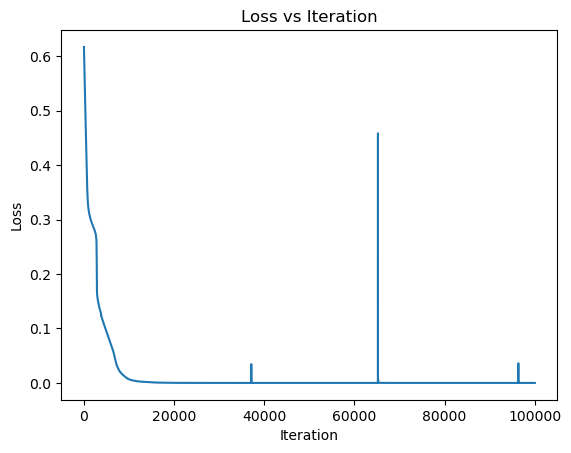

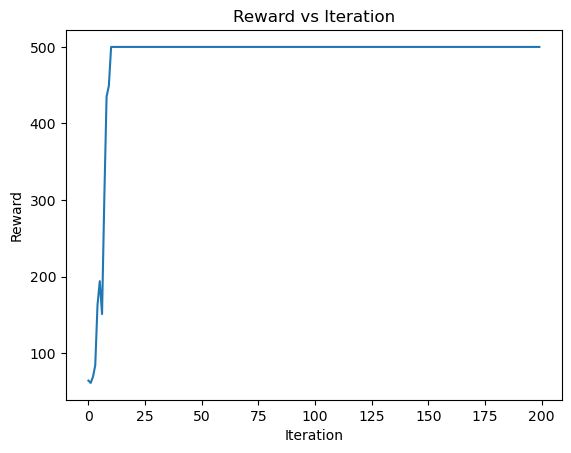

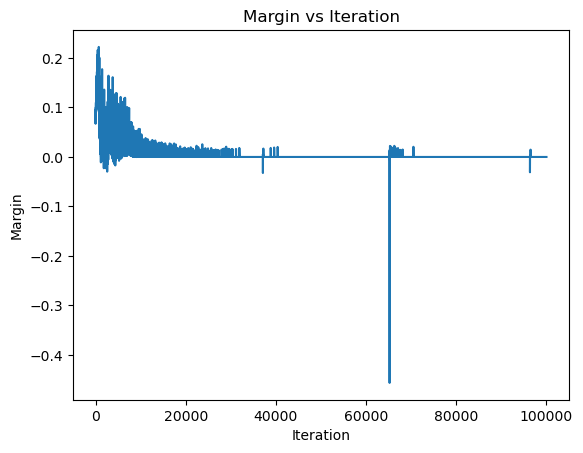

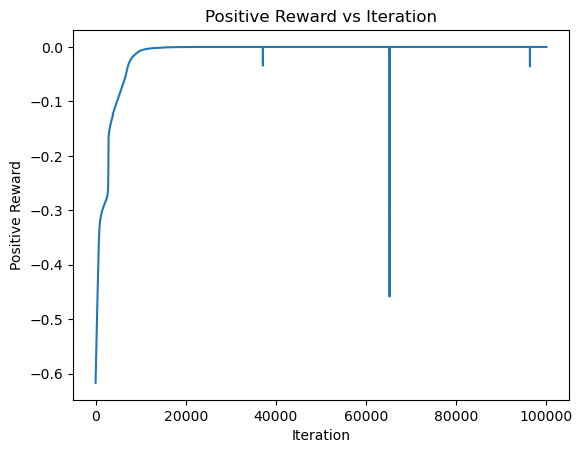

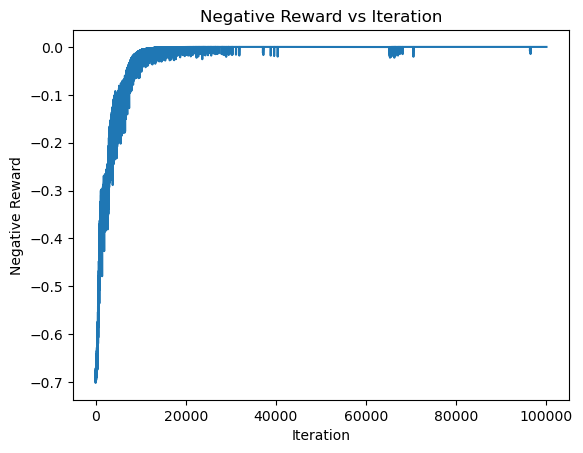

<Figure size 640x480 with 0 Axes>

In [18]:
# save all png to /mnt/nfs/work/c98181/RL/CartPole-v1/DPO

# draw the loss graph
import matplotlib.pyplot as plt
plt.plot(loss_graph)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss vs Iteration")
plt.show()
plt.savefig("/mnt/nfs/work/c98181/RL/CartPole-v1/DPO/loss.png")




# draw the reward graph

plt.plot(eval_rewards)
plt.xlabel("Iteration")
plt.ylabel("Reward")
plt.title("Reward vs Iteration")
plt.show()
plt.savefig("/mnt/nfs/work/c98181/RL/CartPole-v1/DPO/reward.png")

# drqw the margin graph
plt.plot(margin_graph)
plt.xlabel("Iteration")
plt.ylabel("Margin")
plt.title("Margin vs Iteration")
plt.show()
plt.savefig("/mnt/nfs/work/c98181/RL/CartPole-v1/DPO/margin.png")

# draw the positive reward graph
plt.plot(positive_reward_graph)
plt.xlabel("Iteration")
plt.ylabel("Positive Reward")
plt.title("Positive Reward vs Iteration")
plt.show()
plt.savefig("/mnt/nfs/work/c98181/RL/CartPole-v1/DPO/positive_reward.png")

# draw the negative reward graph
plt.plot(negative_reward_graph)
plt.xlabel("Iteration")
plt.ylabel("Negative Reward")
plt.title("Negative Reward vs Iteration")
plt.show()
plt.savefig("/mnt/nfs/work/c98181/RL/CartPole-v1/DPO/negative_reward.png")